In [3]:
%pip install torch torchvision pandas numpy matplotlib pillow seaborn opencv-python 
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import xml.etree.ElementTree as ET
import seaborn as sns
from skimage import io 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import tensorflow 
import keras  
import os
import glob 
from skimage import io 
import skimage
import random 
import numpy as np
import matplotlib.pyplot as plt  

In [7]:
dataset_pth = 'C:/MAMP/htdocs/2025_GP_27/model1/newDataset_images'
annotations_pth = 'C:/MAMP/htdocs/2025_GP_27/model1/newDataset_annotations'

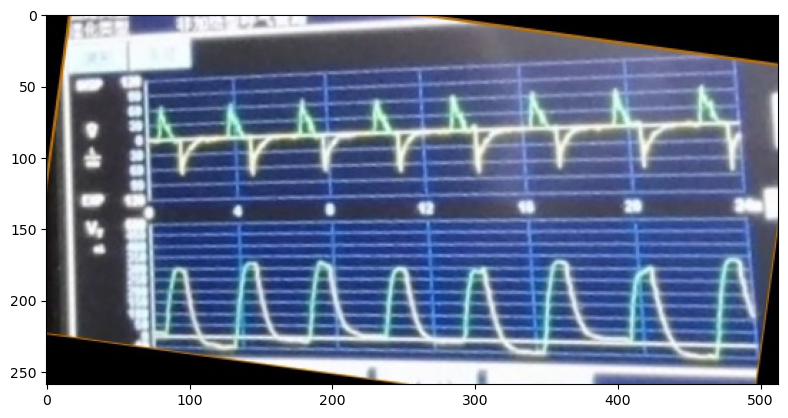

In [12]:
image = io.imread('C:/MAMP/htdocs/2025_GP_27/model1/newDataset_images/000009.jpg')  

# plotting the original image
i, (im1) = plt.subplots(1)
i.set_figwidth(15)
im1.imshow(image)
plt.show()  

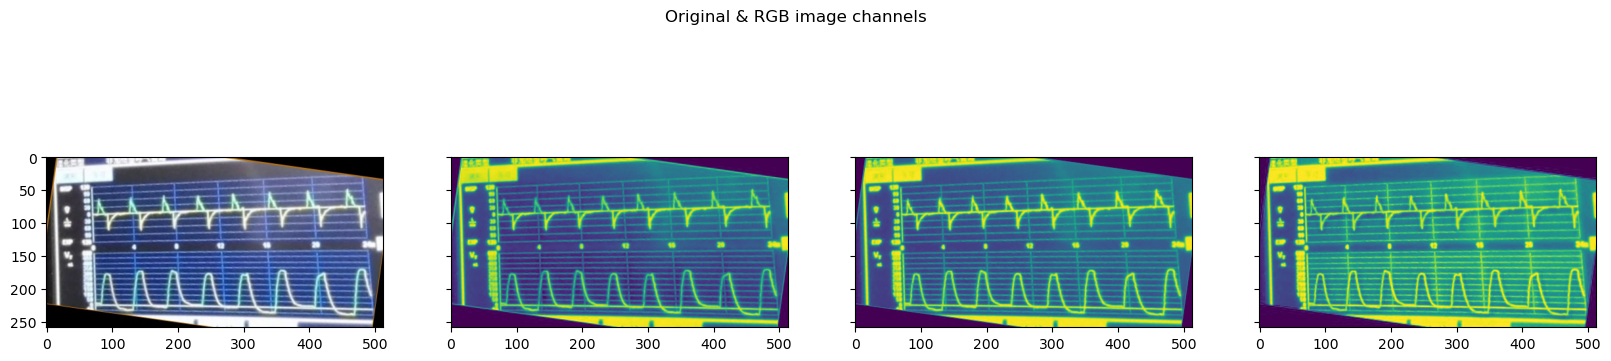

In [13]:
# plotting the original image and the RGB channels  

i, (im1, im2, im3, im4) = plt.subplots(1, 4, sharey=True)
i.set_figwidth(20) 

im1.imshow(image)  #Original image
im2.imshow(image[:, : , 0]) #Red
im3.imshow(image[:, : , 1]) #Green
im4.imshow(image[:, : , 2]) #Blue
i.suptitle('Original & RGB image channels')
plt.show()